## Quantify similarity/divergence of human vs model=f(prompt)

Quantify consistency of binary classifier predictions vs a random binary classifier

In [2]:
import sys
sys.path.append("../../../")

import numpy as np
import pandas as pd

import random
from scipy import stats

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

### 1. Load results

In [3]:
final_columns = ['ea801', 'ea802', 'ea803', 'ea804', 'ea805', 'ea806', 'ea807', 'ea808', 'ea809', 'ea810', 'ea811', 
                 'ea812', 'ea813', 'ea814', 'ea815']
opportunity_cost = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 900, 1200]
# Generate dataframe for evaluation
socioeconomic_factors = ['total_income_level','is_high_wealth','high_education_level','altq','prof_status']
psychological_factors = ['pol_orientation','is_altruist','nature_level','ownership_level','profit_focus','ee_belief']
npv_factors = ['ist5','kdj','kde','kdu','ebj','ebe','ebu','a6']
columns_to_exclude_ols = ['success', 'label', 'temperature', 'decision', 'key', 
                      'citizen_type', 'profit_focus_long', 'profit_focus_short', 
                      'ownership_level_Medium', 'ownership_level_High', 
                      'nature_level_High', 'nature_level_Medium', 
                      'pol_orientation_left', 'pol_orientation_right', 
                      'pol_orientation_center', 'is_altruist']

df_sample = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_completed_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')
df_questions = pd.read_csv("../../../data/ariadne/heating_buildings/questions_selected_survey_mapper_encoded.csv", sep=';', encoding='utf-8', on_bad_lines='skip')
df_sel_complete_pol_ta_clean = pd.read_csv("../../../data/ariadne/heating_buildings/df_c1t1_sample_100_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')

# 2. GPT-4 emotional - Ta: 0.1
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240108_1000/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
output_file2 = '../../../data/ariadne/heating_buildings/experiment_1/20240108_2341/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_1 = pd.read_csv(output_file)
df_synthetic_2 = pd.read_csv(output_file2)
df_synthetic_4_emotional_0_1 = pd.concat([df_synthetic_1,df_synthetic_2])

# 2. GPT-3.5 emotional - Ta: 0.1
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240108_0849/recurrent_gpt-3.5-turbo-1106-t_0.1_qa.csv'
df_synthetic_3_5_emotional_0_1 = pd.read_csv(output_file)

### 2. Calculate model classification consistency

In [5]:
def calculate_consistency(df, id_col, pred_col):
    """
    Calculate the consistency of predictions for each ID in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing IDs and predictions
    id_col (str): Name of the column containing IDs
    pred_col (str): Name of the column containing predictions

    Returns:
    dict: Dictionary with IDs as keys and consistency as values
    """
    # Group by ID and find the most common prediction and its count for each ID
    grouped = df.groupby(id_col)[pred_col].agg(lambda x: x.value_counts().head(1))

    # Calculate consistency as the count of the most common prediction divided by the total count for that ID
    consistency = (grouped / df[id_col].value_counts()).to_dict()

    return consistency

def create_random_prediction_df(original_df):
    # Get the number of predictions per ID from the original DataFrame
    num_preds_per_id = len(original_df)
    random_decisions = [random.choice([1, 2]) for _ in range(num_preds_per_id)]
    original_df['ran_choice'] = random_decisions

    return original_df

def plot_confidence_interval(kde_x, kde_y, ci, color, ax):
    # Find the y-values for the KDE that fall within the confidence interval
    ci_kde_y = kde_y[(kde_x >= ci[0]) & (kde_x <= ci[1])]
    ci_kde_x = kde_x[(kde_x >= ci[0]) & (kde_x <= ci[1])]
    
    # Fill the area under the curve where the KDE falls within the confidence interval
    ax.fill_between(ci_kde_x, 0, ci_kde_y, color=color, alpha=0.5)

def plot_consistency_comparison(consistency_classifier, consistency_random, title):
    classifier_values = list(consistency_classifier.values())
    random_values = list(consistency_random.values())

    # Calculate the mean and standard error of the mean (SEM)
    classifier_mean = np.mean(classifier_values)
    random_mean = np.mean(random_values)
    classifier_sem = stats.sem(classifier_values)
    random_sem = stats.sem(random_values)

    # Determine the confidence intervals
    confidence_level = 0.95
    classifier_ci = stats.t.interval(confidence_level, len(classifier_values)-1, 
                                     loc=classifier_mean, scale=classifier_sem)
    random_ci = stats.t.interval(confidence_level, len(random_values)-1, 
                                 loc=random_mean, scale=random_sem)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate the KDE for the classifier and random values
    sns_kde_classifier = sns.kdeplot(classifier_values, ax=ax, color="blue", label='Classifier Consistency')
    sns_kde_random = sns.kdeplot(random_values, ax=ax, color="orange", label='Random Classifier Consistency')

    # Get the x and y data of the kde curve
    kde_x_classifier, kde_y_classifier = sns_kde_classifier.get_lines()[0].get_data()
    kde_x_random, kde_y_random = sns_kde_random.get_lines()[0].get_data()

    # Add the confidence intervals to the plot
    plot_confidence_interval(kde_x_classifier, kde_y_classifier, classifier_ci, color="blue", ax=ax)
    plot_confidence_interval(kde_x_random, kde_y_random, random_ci, color="orange", ax=ax)

    # Add a vertical line for the mean
    plt.axvline(classifier_mean, color='blue', linestyle='--')
    plt.axvline(random_mean, color='orange', linestyle='--')

    # Add labels and title
    plt.title(title)
    plt.xlabel('Consistency')
    plt.ylabel('Density')

    # Show the plot with a legend
    plt.legend()

    # Show the plot
    plt.show()

def pivot_dataframe(df, decision_columns):
    """
    Pivot the DataFrame to have one decision per row.

    Parameters:
    df (pd.DataFrame): Original DataFrame
    decision_columns (list): List of column names representing decisions

    Returns:
    pd.DataFrame: Transformed DataFrame
    """
    pivoted_df = pd.DataFrame()

    for _, row in df.iterrows():
        for decision in decision_columns:
            temp_df = pd.DataFrame({
                'key': [row['key']],
                'decision': [decision],
                'choice': [row[decision]],
                'label': [row['label']],
                'temperature': [row['temperature']],
                'iter': [row['iter']],
                'success': [row['success']]
            })
            pivoted_df = pd.concat([pivoted_df, temp_df], ignore_index=True)

    return pivoted_df

95 99


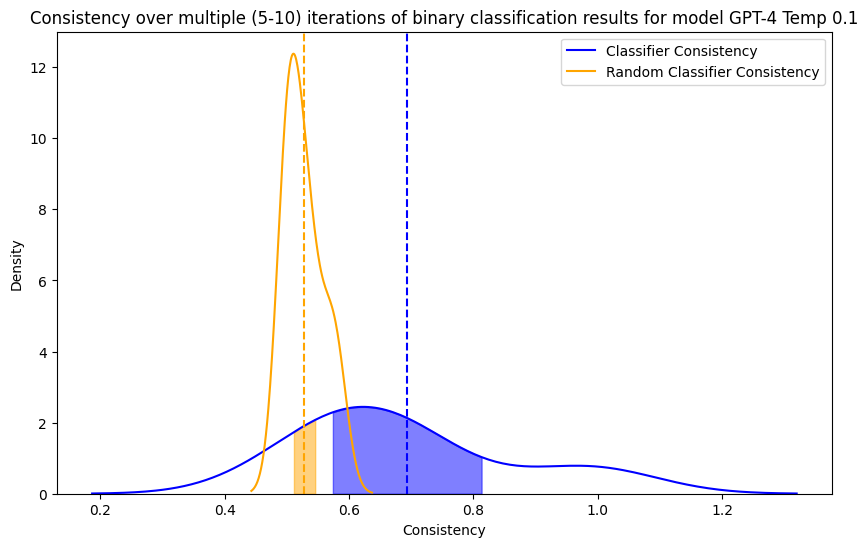

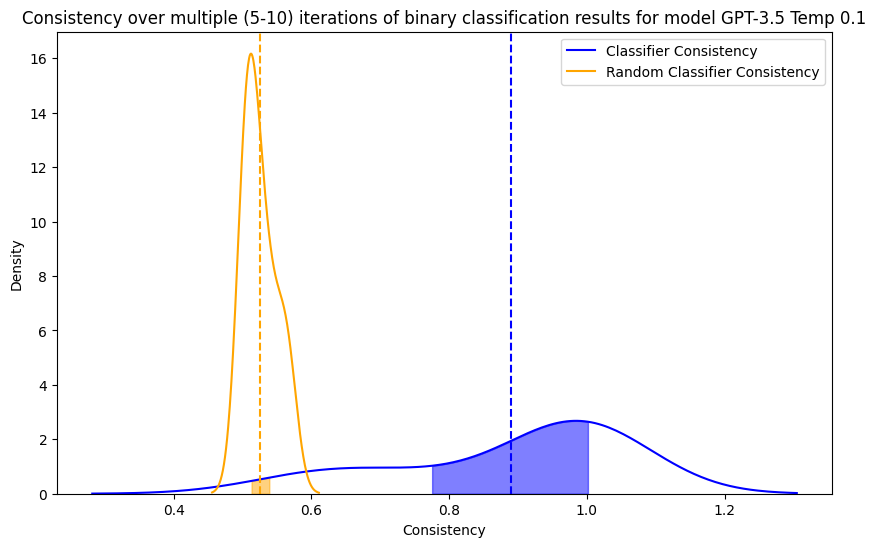

In [6]:
model_names = ['GPT-4 Temp 0.1', 'GPT-3.5 Temp 0.1']
pivoted_df_gpt4 = pivot_dataframe(df_synthetic_4_emotional_0_1, final_columns)
pivoted_df_gpt35 = pivot_dataframe(df_synthetic_3_5_emotional_0_1, final_columns)
print(len(df_synthetic_4_emotional_0_1),len(df_synthetic_3_5_emotional_0_1))

for i,df in enumerate([pivoted_df_gpt4, pivoted_df_gpt35]):
    classifier_consistency = calculate_consistency(df, 'key', 'choice')
    random_df = create_random_prediction_df(df)
    random_consistency = calculate_consistency(random_df, 'key', 'ran_choice')
    plot_consistency_comparison(classifier_consistency, random_consistency, f"Consistency over multiple (5-10) iterations of binary classification results for model {model_names[i]}")